<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Данные-о-максимальной-располагаемой-мощности-группы-СЭС" data-toc-modified-id="Данные-о-максимальной-располагаемой-мощности-группы-СЭС-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Данные о максимальной располагаемой мощности группы СЭС</a></span></li><li><span><a href="#Данные-о-фактической-мощности-группы-СЭС" data-toc-modified-id="Данные-о-фактической-мощности-группы-СЭС-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Данные о фактической мощности группы СЭС</a></span></li><li><span><a href="#Метеоданные" data-toc-modified-id="Метеоданные-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Метеоданные</a></span></li><li><span><a href="#Создание-обобщенного-датафрейма" data-toc-modified-id="Создание-обобщенного-датафрейма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание обобщенного датафрейма</a></span></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></div>

# <p style='text-align:center; color:blue'> Прогнозирование нагрузки группы солнечных электростанций Оренбургской энергосистемы </p><a class="tocSkip">
    
## <p style='text-align:center; color:blue'> Часть 1. Подготовка данных </p><a class="tocSkip">
    

In [1]:
# загрузка стандартных библиотек для обработки и визуализации данных

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=2)
import matplotlib.pyplot as plt
from datetime import datetime

from pandas import Series
sns.set(style="darkgrid")
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
sns.set(style="darkgrid")

### Данные о максимальной располагаемой мощности группы СЭС

In [2]:
df_max = pd.read_csv(r'E:\EZG\VIE\raw_data\train\ВИЭ ОРЕНБ МАКС ПДГ_correct.csv', sep=';')

# заменяем разделитель запятую на точку
df_max['max'] = df_max['max'].values.astype(str)
df_max['max'] = df_max['max'].apply(lambda x: float(x.split()[0].replace(',', '.')))

df_max = df_max.dropna(subset=['date'])

# приводим формат времени к типу datetime
df_max['date'] = pd.to_datetime(df_max['date'], format='%d.%m.%Y %H:%M')
display(df_max.head())
print(df_max.info())

,date,max
0,2020-01-01 03:00:00,0.0
1,2020-01-01 04:00:00,0.0
2,2020-01-01 05:00:00,0.0
3,2020-01-01 06:00:00,0.0
4,2020-01-01 07:00:00,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27792 entries, 0 to 27791
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    27792 non-null  datetime64[ns]
 1   max     27792 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 651.4 KB
None


Проверяем корректность данных на предмет пропусков и артефактов

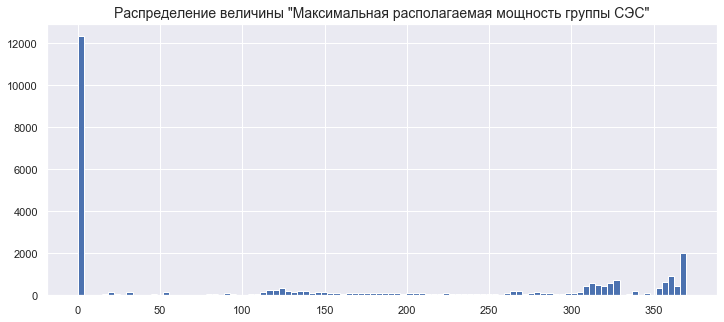

In [3]:
plt.figure(figsize=(12,5))
plt.title('Распределение величины "Максимальная располагаемая мощность группы СЭС"', fontsize=14)
#sns_plot = sns.distplot(df_max['max'])
df_max['max'].hist(bins=100)

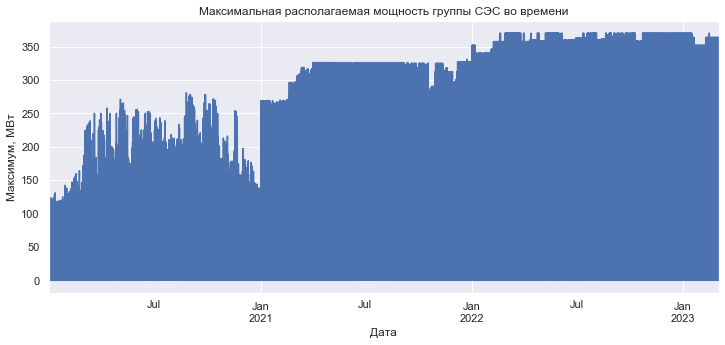

In [4]:
fig, ax = plt.subplots(figsize=(12,5),
                       )
df_max.plot(x="date", y="max", ax=ax)
ax.set(title='Максимальная располагаемая мощность группы СЭС во времени', 
       xlabel='Дата', 
       ylabel='Максимум, МВт')
ax.legend().set_visible(False)

**Вывод:**
В нашем распоряжении почасовые данные по максимально располагаемой мощности группы СЭС с 01.01.2020 по 04.03.2023. Данные не имеют пропусков и они корректны. 

### Данные о фактической мощности группы СЭС

In [5]:
df_fact = pd.read_csv(r'E:\EZG\VIE\raw_data\train\ВИЭ Оренбург факт_correct.csv', sep=';')
df_fact['fact'] = df_fact['fact'].values.astype(str)
df_fact['fact'] = df_fact['fact'].apply(lambda x: float(x.split()[0].replace(',', '.')))
df_fact = df_fact.dropna(subset=['date'])
df_fact['date'] = pd.to_datetime(df_fact['date'], format='%d.%m.%Y %H:%M')
display(df_fact.head())
print(df_fact.info())

,date,fact
0,2022-01-09 03:00:00,0.01054
1,2022-01-09 04:00:00,0.01054
2,2022-01-09 05:00:00,0.01054
3,2022-01-09 06:00:00,0.01054
4,2022-01-09 07:00:00,0.01054


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10104 entries, 0 to 10103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10104 non-null  datetime64[ns]
 1   fact    10104 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 236.8 KB
None


В ночные часы, когда нагрузка нулевая, значение факта по неизвестным причинам не равно нулю, и заполняется фиксированным околонулевым значением. Заменим такие значения на 0. Для этого выделяем дубликаты по полю 'fact' и заменяем такие значения на 0.

In [6]:
df_fact['duplicated'] = df_fact.duplicated(subset=['fact'], keep=False)

df_fact['fact'].where((df_fact['duplicated'] != True) & (df_fact['fact'] > 1), 
                      0,
                      inplace=True)

df_fact = df_fact.drop(columns='duplicated')
df_fact.head(10)

,date,fact
0,2022-01-09 03:00:00,0.00000
1,2022-01-09 04:00:00,0.00000
2,2022-01-09 05:00:00,0.00000
3,2022-01-09 06:00:00,0.00000
4,2022-01-09 07:00:00,0.00000
5,2022-01-09 08:00:00,0.00000
6,2022-01-09 09:00:00,0.00000
7,2022-01-09 10:00:00,0.00000
8,2022-01-09 11:00:00,21.37372
9,2022-01-09 12:00:00,115.63291


Проверяем корректность данных на предмет пропусков и артефактов

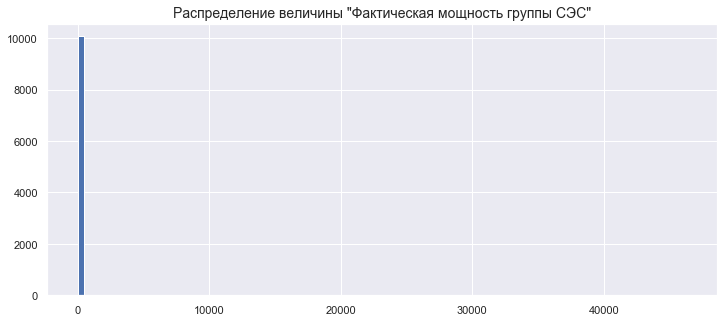

In [7]:
plt.figure(figsize=(12,5))
plt.title('Распределение величины "Фактическая мощность группы СЭС"', fontsize=14)
df_fact['fact'].hist(bins=100)

Судя по виду распределения, датасет имеет выбросы-артефакты. Как видно из графика максимальной располагаемо мощности, уровень фактической генерации не может превышать величину 400 МВт. Выберем значения факта, большие 400 МВт. 

In [8]:
df_fact[df_fact['fact'] > 400]

,date,fact
223,2022-01-18 10:00:00,15342.0
775,2022-02-10 10:00:00,35339.0
1589,2022-03-16 08:00:00,45809.0
2296,2022-04-14 19:00:00,32813.0
2489,2022-04-22 20:00:00,37316.0
2572,2022-04-26 07:00:00,30286.0
2825,2022-05-06 20:00:00,26268.0
2955,2022-05-12 06:00:00,40909.0
3041,2022-05-15 20:00:00,22859.0
3099,2022-05-18 06:00:00,31809.0


Вероятнее всего, мы имеем дело с неправильным порядком значений. Это можно проверить, посмотрев значения в точках, соседних с теми, где мы имеем артефакты. Например, точки

222 "2022-01-18 9:00:00"

224 "2022-01-18 11:00:00":

In [9]:
df_fact.loc[[222,224]]

,date,fact
222,2022-01-18 09:00:00,0.00000
224,2022-01-18 11:00:00,46.34436


Вероятнее всего, в точке 223 правильное значение не 15342 МВт, а 15,342 МВт. С учетом этого, заменяем значения в артефактных точках.

In [10]:
df_fact['fact'] = np.where(df_fact['fact'] > 400, df_fact['fact']/1000, df_fact['fact'])

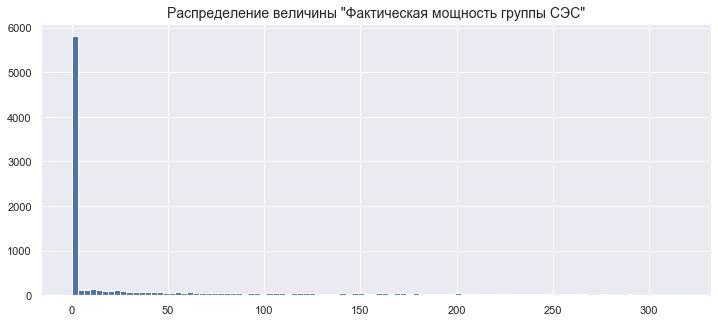

In [11]:
plt.figure(figsize=(12,5))
plt.title('Распределение величины "Фактическая мощность группы СЭС"', fontsize=14)
df_fact['fact'].hist(bins=100)

Теперь распределение величины фактической генерации похоже на правду. Посмотрим на распределений этой величины в разрезе времени

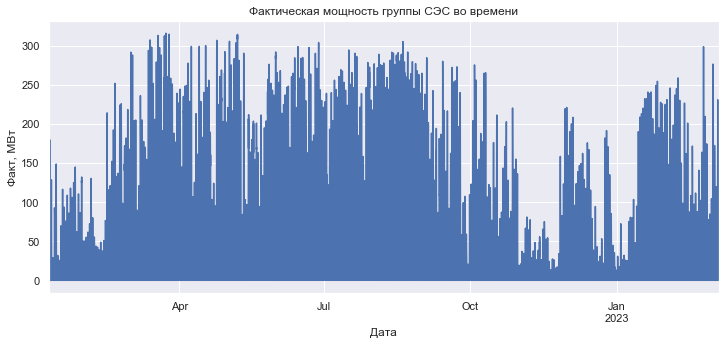

In [12]:
fig, ax = plt.subplots(figsize=(12,5),
                       )
df_fact.plot(x="date", y="fact", ax=ax)
ax.set(title='Фактическая мощность группы СЭС во времени', 
       xlabel='Дата', 
       ylabel='Факт, МВт')
ax.legend().set_visible(False)

**Вывод:**
В нашем распоряжении почасовые данные по максимально располагаемой мощности группы СЭС с 01.09.2022 по 06.03.2023. Данные не имеют пропусков. Имели место ошибки в данных. Артефакты приведены к реальным значениям. 

### Метеоданные

In [13]:
df_meteo = pd.read_csv(r'E:\EZG\VIE\raw_data\train\погода Оренбург.csv', sep=';', encoding='cp1251')
df_meteo.head()

,date,temp,cloudiness,rainfall
0,"01.01.2020, ср, 00","-1,6",2,б/о
1,"01.01.2020, ср, 03","-1,2",2,Слабый снег (1.0 из 3.0)
2,"01.01.2020, ср, 06","-0,6",2,Умеренный снег (2.0 из 3.0)
3,"01.01.2020, ср, 09","-0,5",2,Умеренный снег (2.0 из 3.0)
4,"01.01.2020, ср, 12","-0,1",2,Умеренный снег (2.0 из 3.0)


Данные требуют преобразования. Во-первых, необходимо привести время из московского к уральскому и удалить день недели.

In [14]:
df_meteo[['date_1', 'day', 'hour']] = df_meteo['date'].str.split(', ', expand=True)

#приводим время к уральскому
df_meteo['hour'] = df_meteo['hour'].map(int)
df_meteo['hour'] = df_meteo['hour'] + 2
df_meteo['hour'] = df_meteo['hour'].map(str)

df_meteo['date'] = df_meteo['date_1'].map(str) + ' ' + df_meteo['hour'].map(str)
df_meteo = df_meteo.drop(columns=['date_1', 'day', 'hour'])
df_meteo.head(10)

,date,temp,cloudiness,rainfall
0,01.01.2020 2,"-1,6",2,б/о
1,01.01.2020 5,"-1,2",2,Слабый снег (1.0 из 3.0)
2,01.01.2020 8,"-0,6",2,Умеренный снег (2.0 из 3.0)
3,01.01.2020 11,"-0,5",2,Умеренный снег (2.0 из 3.0)
4,01.01.2020 14,"-0,1",2,Умеренный снег (2.0 из 3.0)
5,01.01.2020 17,"-0,5",2,Умеренный снег (2.0 из 3.0)
6,01.01.2020 20,"-0,6",2,Слабый снег (1.0 из 3.0)
7,01.01.2020 23,"-0,7",2,Слабый снег (1.0 из 3.0)
8,02.01.2020 2,"-0,6",2,Умеренный снег (2.0 из 3.0)
9,02.01.2020 5,"0,1",2,Умеренный снег (2.0 из 3.0)


In [15]:
# приводим дату к формату времени datetime
df_meteo['date'] = pd.to_datetime(df_meteo['date'], format='%d.%m.%Y %H')
df_meteo.head(10)

,date,temp,cloudiness,rainfall
0,2020-01-01 02:00:00,"-1,6",2,б/о
1,2020-01-01 05:00:00,"-1,2",2,Слабый снег (1.0 из 3.0)
2,2020-01-01 08:00:00,"-0,6",2,Умеренный снег (2.0 из 3.0)
3,2020-01-01 11:00:00,"-0,5",2,Умеренный снег (2.0 из 3.0)
4,2020-01-01 14:00:00,"-0,1",2,Умеренный снег (2.0 из 3.0)
5,2020-01-01 17:00:00,"-0,5",2,Умеренный снег (2.0 из 3.0)
6,2020-01-01 20:00:00,"-0,6",2,Слабый снег (1.0 из 3.0)
7,2020-01-01 23:00:00,"-0,7",2,Слабый снег (1.0 из 3.0)
8,2020-01-02 02:00:00,"-0,6",2,Умеренный снег (2.0 из 3.0)
9,2020-01-02 05:00:00,"0,1",2,Умеренный снег (2.0 из 3.0)


Теперь выделяем поле "вид осадков" и "интенсивность осадков" 

In [16]:
df_meteo['rainfall_type'] = df_meteo['rainfall'].str.split(' ').str[:2].str.join(' ')
df_meteo.head()

,date,temp,cloudiness,rainfall,rainfall_type
0,2020-01-01 02:00:00,"-1,6",2,б/о,б/о
1,2020-01-01 05:00:00,"-1,2",2,Слабый снег (1.0 из 3.0),Слабый снег
2,2020-01-01 08:00:00,"-0,6",2,Умеренный снег (2.0 из 3.0),Умеренный снег
3,2020-01-01 11:00:00,"-0,5",2,Умеренный снег (2.0 из 3.0),Умеренный снег
4,2020-01-01 14:00:00,"-0,1",2,Умеренный снег (2.0 из 3.0),Умеренный снег


In [17]:
df_meteo['rainfall_rate'] = df_meteo['rainfall'].str.split(' ').str[-3]
df_meteo.head()

,date,temp,cloudiness,rainfall,rainfall_type,rainfall_rate
0,2020-01-01 02:00:00,"-1,6",2,б/о,б/о,NaN
1,2020-01-01 05:00:00,"-1,2",2,Слабый снег (1.0 из 3.0),Слабый снег,(1.0
2,2020-01-01 08:00:00,"-0,6",2,Умеренный снег (2.0 из 3.0),Умеренный снег,(2.0
3,2020-01-01 11:00:00,"-0,5",2,Умеренный снег (2.0 из 3.0),Умеренный снег,(2.0
4,2020-01-01 14:00:00,"-0,1",2,Умеренный снег (2.0 из 3.0),Умеренный снег,(2.0


In [18]:
df_meteo['rainfall_rate'] = df_meteo['rainfall_rate'].str.replace('(', '')
df_meteo = df_meteo.drop(columns='rainfall')
df_meteo['rainfall_rate'] = df_meteo['rainfall_rate'].astype(float)
df_meteo['temp'] = df_meteo['temp'].apply(lambda x: float(x.replace(',', '.')))
df_meteo['cloudiness'] = df_meteo['cloudiness'].apply(lambda x: float(x.replace(',', '.')))
df_meteo.head()

,date,temp,cloudiness,rainfall_type,rainfall_rate
0,2020-01-01 02:00:00,-1.6,2.0,б/о,NaN
1,2020-01-01 05:00:00,-1.2,2.0,Слабый снег,1.0
2,2020-01-01 08:00:00,-0.6,2.0,Умеренный снег,2.0
3,2020-01-01 11:00:00,-0.5,2.0,Умеренный снег,2.0
4,2020-01-01 14:00:00,-0.1,2.0,Умеренный снег,2.0


Анализируем полученную таблицу

In [19]:
df_meteo.describe()

,temp,cloudiness,rainfall_rate
count,9264.000000,9264.000000,2014.000000
mean,5.880473,1.209478,1.110228
std,14.601452,0.775258,0.317974
min,-34.400000,0.000000,1.000000
25%,-5.525000,0.400000,1.000000
50%,5.600000,1.400000,1.000000
75%,17.600000,2.000000,1.000000
max,40.000000,2.000000,3.000000


In [20]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9264 entries, 0 to 9263
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           9264 non-null   datetime64[ns]
 1   temp           9264 non-null   float64       
 2   cloudiness     9264 non-null   float64       
 3   rainfall_type  9264 non-null   object        
 4   rainfall_rate  2014 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 362.0+ KB


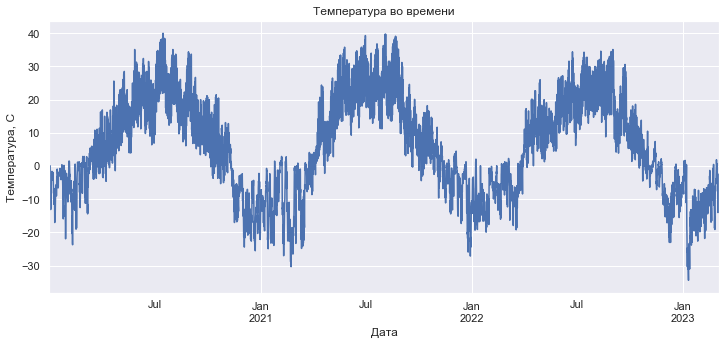

In [21]:
fig, ax = plt.subplots(figsize=(12,5),
                       )
df_meteo.plot(x="date", y="temp", ax=ax)
ax.set(title='Температура во времени', 
       xlabel='Дата', 
       ylabel='Температура, С')
ax.legend().set_visible(False)

**Вывод:**
В нашем распоряжении данные о погоде в г.Оренбург с 01.01.2020 по 03.03.2023 с шагом в 3 часа. Данные не имеют пропусков и артефактов.

### Создание обобщенного датафрейма

Объединяем данные о максимальной располагаемой мощности, фактической генерации и метеофакторах.

In [23]:
df = df_max.merge(df_fact, on='date', how='inner')

In [24]:
df = df.merge(df_meteo, on='date', how='left')

In [25]:
df = df.drop(index=[0,1])
df = df.reset_index(drop=True)
df.head()

,date,max,fact,temp,cloudiness,rainfall_type,rainfall_rate
0,2022-01-09 05:00:00,0.0,0.0,-16.9,0.0,б/о,NaN
1,2022-01-09 06:00:00,0.0,0.0,NaN,NaN,NaN,NaN
2,2022-01-09 07:00:00,0.0,0.0,NaN,NaN,NaN,NaN
3,2022-01-09 08:00:00,0.0,0.0,-17.6,0.0,б/о,NaN
4,2022-01-09 09:00:00,2.0,0.0,NaN,NaN,NaN,NaN


Вследствие того, что данные о погоде имеют шаг в 3 часа, в нашем итоговом датасете имеются пропуски. Заполним их с помощью линейной интерполяции

In [26]:
# функция заполнения пропусков на основе линейной интерполяции
def fill_nan(column):
    flag = 0
    na=[]
    for index in df.index:
        if pd.notna(df.loc[index, column]):
            if flag == 0:
                first = index
                flag = 1
            elif flag == 1:
                last = index
                delta = (df.loc[last, column] - df.loc[first, column])/(len(na)+1)
                for i in range(len(na)):
                    df.loc[na[i], column] = df.loc[na[i]-1, column] + delta
                na=[]
                first = last
        else:
            na.append(index)

# заполняем пропуски в полях temp и cloudiness            
fill_nan('temp') 
fill_nan('cloudiness')

df = df.dropna(subset=['temp'])

display(df)

,date,max,fact,temp,cloudiness,rainfall_type,rainfall_rate
0,2022-01-09 05:00:00,0.0,0.0,-16.900000,0.000000,б/о,NaN
1,2022-01-09 06:00:00,0.0,0.0,-17.133333,0.000000,NaN,NaN
2,2022-01-09 07:00:00,0.0,0.0,-17.366667,0.000000,NaN,NaN
3,2022-01-09 08:00:00,0.0,0.0,-17.600000,0.000000,б/о,NaN
4,2022-01-09 09:00:00,2.0,0.0,-17.533333,0.133333,NaN,NaN
...,...,...,...,...,...,...,...
10046,2023-03-03 19:00:00,310.0,0.0,-2.633333,1.866667,NaN,NaN
10047,2023-03-03 20:00:00,0.0,0.0,-2.700000,1.800000,б/о,NaN
10048,2023-03-03 21:00:00,0.0,0.0,-2.600000,1.866667,NaN,NaN
10049,2023-03-03 22:00:00,0.0,0.0,-2.500000,1.933333,NaN,NaN


In [27]:
# пропуски в поле rainfall_typ заполняем по методу 'ffill' "из предыдущего"
df['rainfall_type'] = df['rainfall_type'].fillna(method='ffill')

In [28]:
# пропуски в поле 'rainfall_rate' заполняем по прнципу: 
# если тип осадков "без осадков", то уровень осадков равен 0
df.rainfall_rate = np.where(df.rainfall_type == 'б/о', 
                            0, 
                            df.rainfall_rate)

In [29]:
# для строк, в которых осадки имели место (то есть определен их тип), но отсутствует значение 
# rainfall_rate, пропуски в поле rainfall_rate заполняем линейной интерполяцией - принимаем допущение
# о том, что осадки не заканчиваются резко, а плавно переходят от одного состояния к другому.
fill_nan('rainfall_rate') 

Вводим в наш датасет поле load_rate - уровень загрузки станций, равный отношению фактической генерации к величине располагаемой мощности. Кроме того выделяем поля с номером месяца и номером часа

In [30]:
df['load_rate'] = np.where(df['max']==0, 0, df['fact']/df['max'])
df['month'] = df['date'].dt.month
df['hour'] = df['date'].dt.hour
df.head(5)

,date,max,fact,temp,cloudiness,rainfall_type,rainfall_rate,load_rate,month,hour
0,2022-01-09 05:00:00,0.0,0.0,-16.900000,0.000000,б/о,0.0,0.0,1,5
1,2022-01-09 06:00:00,0.0,0.0,-17.133333,0.000000,б/о,0.0,0.0,1,6
2,2022-01-09 07:00:00,0.0,0.0,-17.366667,0.000000,б/о,0.0,0.0,1,7
3,2022-01-09 08:00:00,0.0,0.0,-17.600000,0.000000,б/о,0.0,0.0,1,8
4,2022-01-09 09:00:00,2.0,0.0,-17.533333,0.133333,б/о,0.0,0.0,1,9


Поле "rainfall_type" заменяем на индикативные переменные

In [31]:
df = pd.get_dummies(df, columns=["rainfall_type"])
df.head(2)

,date,max,fact,temp,cloudiness,rainfall_rate,load_rate,month,hour,rainfall_type_Слабый дождь,rainfall_type_Слабый снег,rainfall_type_Умеренный дождь,rainfall_type_Умеренный снег,rainfall_type_б/о
0,2022-01-09 05:00:00,0.0,0.0,-16.900000,0.0,0.0,0.0,1,5,0,0,0,0,1
1,2022-01-09 06:00:00,0.0,0.0,-17.133333,0.0,0.0,0.0,1,6,0,0,0,0,1


In [37]:
df.tail(1)

,date,max,fact,temp,cloudiness,rainfall_rate,load_rate,month,hour,rainfall_type_Слабый дождь,rainfall_type_Слабый снег,rainfall_type_Умеренный дождь,rainfall_type_Умеренный снег,rainfall_type_б/о
10050,2023-03-03 23:00:00,0.0,0.0,-2.4,2.0,1.0,0.0,3,23,0,1,0,0,0


Сохраняем готовый датасет в отдельный csv файл.

In [35]:
df.to_csv('E:\EZG\VIE\solar_df\solar_df.csv')

### Выводы:


Проанализировали имеющиеся в нашем распоряжении данные. Выявили и обработали пропуски и артефакты в данных. 

При подготовке данных были приняты следующие допущения:
1. Метеофакторы изменяются во аремени линейно;
2. Метеофакторы в каждый момент времени одинаковы для всей территории, на которой расположены электростанции.

В результате имеем датасет из 10051 часового наблюдения с по 09.01.2022 по 03.03.2023. 

Целевая переменная - load_rate.

10 влияющих факторов:
  
* temp, 
* cloudiness, 
* rainfall_rate, 
* month, 
* hour, 
* rainfall_type_Слабый дождь, 
* rainfall_type_Слабый снег, 
* rainfall_type_Умеренный дождь, 
* rainfall_type_Умеренный снег, 
* rainfall_type_б/о'